In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from hyperopt import hp, tpe, fmin
from tqdm import tqdm

from collections import OrderedDict
import itertools
import datetime
from joblib import Parallel, delayed

from models.seir.seir_testing import SEIR_Testing
from data.dataloader import get_global_data, get_indian_data
from utils.plotting import create_plots
from utils.generic import init_params

In [3]:
df_master = get_global_data()

In [4]:
df_tested, df_statewise, df_state_time_series, df_india_time_series, df_districtwise, df_raw_data, df_travel_history = get_indian_data()

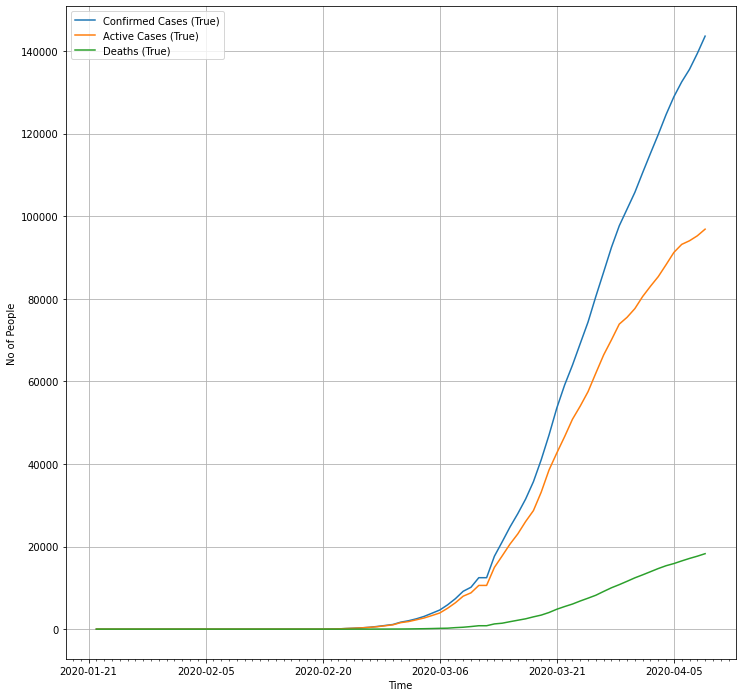

In [5]:
df_country = df_master[df_master['Country/Region'] == 'Italy'].loc[:, 'Date':].groupby('Date').sum().reset_index()
df_country[df_country['ConfirmedCases'] > 0]
last_time = len(df_country['Date'])

states_time_matrices = []
vanilla_params, testing_params, state_init_values = init_params(R0=3, T_inc=5.2, T_inf=2.9, T_death=1, N=6.05e7, init_infected=1)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['ConfirmedCases'], label='Confirmed Cases (True)')
# ax.plot(np.array(df_country['Date']), states_time_matrix[2] + states_time_matrix[4] + 
#         states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
#         states_time_matrix[9] + states_time_matrix[10], label='Confirmed Cases (Predicted)')
ax.plot(df_country['Date'], df_country['ActiveCases'], label='Active Cases (True)')
# ax.plot(df_country['Date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
#         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label='Active Cases (Predicted)')
ax.plot(df_country['Date'], df_country['Deaths'], label='Deaths (True)')
# ax.plot(df_country['Date'], states_time_matrix[10], label='Deaths (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

In [6]:
def _calc_rmse(y_true, y_pred, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    loss = np.mean(ape)
    return loss

def calc_loss(states_time_matrix, df_country):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    pred_conf_cases = states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + states_time_matrix[9] + states_time_matrix[10]
    pred_active_cases = states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    loss = np.sqrt(np.mean((pred_conf_cases - df_country['ConfirmedCases'])**2)) + np.sqrt(np.mean((pred_active_cases - df_country['ActiveCases'])**2))
    return loss

def calc_death_loss(states_time_matrix, df_country):
    return np.sqrt(np.mean((states_time_matrix[10] - df_country['Deaths'])**2))

def get_country_dataframe(df_master, country):
    df_country = df_master[df_master['Country/Region'] == country].loc[:, 'Date':].groupby('Date').sum().reset_index()
    df_country = df_country[df_country['ConfirmedCases'] > 0]
    total_days = len(df_country['Date'])
    df_country.reset_index(drop=True, inplace=True)
    return df_country

def solve_and_compute_loss(params_dict, df_country, total_days):
    vanilla_params, testing_params, state_init_values = init_params(**params_dict)
    solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
    sol = solver.solve_ode(total_no_of_days=total_days - 1, time_step=1, method='Radau')
    states_time_matrix = (sol.y*vanilla_params['N']).astype('int')
    return calc_case_loss(states_time_matrix, df_country)

def _create_dict(param_names, values, default_params):
    params_dict = {param_names[i]: values[i] for i in range(len(values))}
    params_dict = {**params_dict, **default_params}
    return params_dict
    
def gridsearch(country='Italy', N=6.05e7, offset=7):
    df_country = get_country_dataframe(df_master, country)
    df_country_fitting = df_country.loc[offset:, :]
    df_country_fitting.reset_index(drop=True, inplace=True)
    
    total_days = len(df_country_fitting['Date'])
    init_infected = df_country_fitting.loc[0, 'ConfirmedCases']
    start_date = df_country_fitting.loc[0, 'Date']
    intervention_date = datetime.datetime.strptime('2020-03-09', '%Y-%m-%d')
    
    default_params = {
        'N' : N,
        'init_infected' : init_infected,
        'intervention_day' : (intervention_date - start_date).days + 14
    }
    
    param_ranges = {
        'R0' : np.linspace(1, 4.8, 20),
        'T_inc' : np.linspace(1, 5.2, 22),
        'T_inf' : np.linspace(1, 5, 21),
        'intervention_amount' : np.linspace(0.4, 1, 31)
    }
    
    rangelists = list(param_ranges.values())
    cartesian_product_tuples = itertools.product(*rangelists)
    list_of_param_dicts = [_create_dict(list(param_ranges.keys()), values, default_params) for values in cartesian_product_tuples]
    
    loss_array = Parallel(n_jobs=40)(delayed(solve_and_compute_loss)(params_dict, df_country_fitting, total_days) for params_dict in tqdm(list_of_param_dicts))
                
    return loss_array, list_of_param_dicts, df_country, df_country_fitting

In [7]:
loss_array, params_array, df_country, df_country_fitting = gridsearch()

100%|██████████| 286440/286440 [05:36<00:00, 850.22it/s] 


In [8]:
print(np.min(loss_array))
print(params_array[np.argmin(loss_array)])

13334.59898930206
{'R0': 2.0, 'T_inc': 1.2, 'T_inf': 3.0, 'intervention_amount': 0.42000000000000004, 'N': 60500000.0, 'init_infected': 3, 'intervention_day': 45}


--Return--
> <ipython-input-10-c092a0cc3772>(6)<module>()->None
-> import pdb; pdb.set_trace()


(Pdb)  c


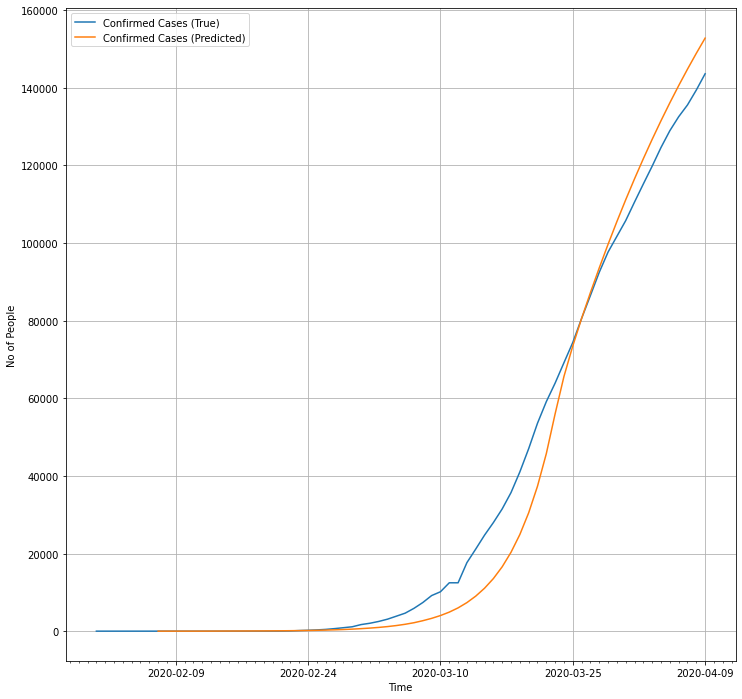

In [10]:
vanilla_params, testing_params, state_init_values = init_params(**params_array[np.argmin(loss_array)])
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(total_no_of_days=len(df_country_fitting['Date']) - 1, time_step=1, method='Radau')
states_time_matrix = (sol.y*vanilla_params['N']).astype('int') 

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['ConfirmedCases'], label='Confirmed Cases (True)')
ax.plot(np.array(df_country_fitting['Date']), states_time_matrix[2] + states_time_matrix[4] + 
        states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
        states_time_matrix[9] + states_time_matrix[10], label='Confirmed Cases (Predicted)')
# ax.plot(df_country['Date'], df_country['ActiveCases'], label='Active Cases (True)')
# ax.plot(df_country_fitting['Date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
#         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label='Active Cases (Predicted)')
# ax.plot(df_country['Date'], df_country['Deaths'], label='Deaths (True)')
# ax.plot(df_country_fitting['Date'], states_time_matrix[10], label='Deaths (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

In [13]:
np.sort(loss_array)[:100]

array([13334.5989893 , 13458.07125052, 13650.04267319, 13743.64645137,
       13786.10787642, 14016.09023554, 14044.49565233, 14187.43882742,
       14202.56248401, 14256.23505967, 14456.01092331, 14474.51306787,
       14548.60146655, 14569.63274625, 14740.76010437, 14753.2167926 ,
       14764.60804385, 14787.9531826 , 14844.01895549, 14877.0519967 ,
       14879.43174462, 14963.68721966, 14982.55269039, 14996.02039046,
       15036.44091241, 15286.18354898, 15421.64271423, 15428.75531836,
       15483.47623019, 15486.81833813, 15493.33781505, 15565.51293022,
       15586.21689244, 15648.02038105, 15650.50933371, 15656.59986478,
       15772.89830435, 15787.35909313, 15788.14155852, 15970.04593841,
       15971.15464982, 16491.7319713 , 16517.42154567, 16533.89943582,
       16543.85984554, 16575.40954641, 16577.75287451, 16584.55166396,
       16607.85861861, 16616.51533004, 16654.51231534, 16696.40288609,
       16723.28870398, 16976.45610123, 17024.01074946, 17025.96725782,
      

In [55]:
df_country = get_country_dataframe(df_master, 'Italy')
df_country.loc[4:, :]

,Date,ConfirmedCases,Deaths,RecoveredCases,ActiveCases
4,2020-02-04,2,0,0,2
5,2020-02-05,2,0,0,2
6,2020-02-06,2,0,0,2
7,2020-02-07,3,0,0,3
8,2020-02-08,3,0,0,3
...,...,...,...,...,...
64,2020-04-04,124632,15362,20996,88274
65,2020-04-05,128948,15887,21815,91246
66,2020-04-06,132547,16523,22837,93187
67,2020-04-07,135586,17127,24392,94067
